In [1]:
import csv
import numpy as np
import pylab as plb

In [2]:
%pylab

Using matplotlib backend: WXAgg
Populating the interactive namespace from numpy and matplotlib


In [3]:
#load the csv file and read the file line-by-line
f = open('mu_matrix.csv')
reader = csv.reader(f,delimiter = ',')
lines = [ln for ln in reader]
f.close()

In [4]:
#convert the data into a numpy array
txtarray = np.array(lines)[1:,1:32]
linenames = np.array([[ln.strip() for ln in l] for l in lines])[1:,0]

In [5]:
#extract the DLM and DVM columns
DLM = txtarray[:,0:6]
DVM = txtarray[:,6:13]
steering = txtarray[:,13:]

In [6]:
#convert to floating point data changing N/A to nan's
def convert_to_float(txt_arr):
    nanidx = txt_arr == 'N/A'
    txt_arr[nanidx] = -1
    floatarr = (txt_arr.astype(float)).astype(float)
    floatarr[nanidx] = np.nan
    return floatarr
DLM_float = convert_to_float(DLM)
DVM_float = convert_to_float(DVM)
steering_float = convert_to_float(steering)

In [7]:
#re-stack with the DLM and DVM data collapsed into a single variable
imgarray = np.hstack((np.nanmean(DLM_float,axis=1)[:,np.newaxis],np.nanmean(DVM_float,axis=1)[:,np.newaxis],steering_float))
nanidx = np.isnan(imgarray)
imgarray = imgarray.astype(float)
imgarray = imgarray+0.5
imgarray[nanidx] = 0

/home/flyranch/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:607: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [8]:
#note that iii3 and iii24 as well as hg3 and hg2 are swaped
muscle_names = ['DLM','DVM',
                'b1','b3','b2',
                'i1','i2',
                'iii1','iii24','iii3',
                'hg1','hg3','hg2','hg4',
                'tpv','tpd','ps','ttm','pr','nm']

In [9]:
#load the experimental summary data
f = open('group_summary.csv')
reader = csv.reader(f,delimiter = ',')
lines = [ln for ln in reader]
f.close()
line_info_dict = dict()
for ln in lines[1:]:
    line_info_dict[ln[0]] = {'gal':ln[1],'lex':ln[2],'n(GC)':ln[3],'n(GFP)':ln[4]}

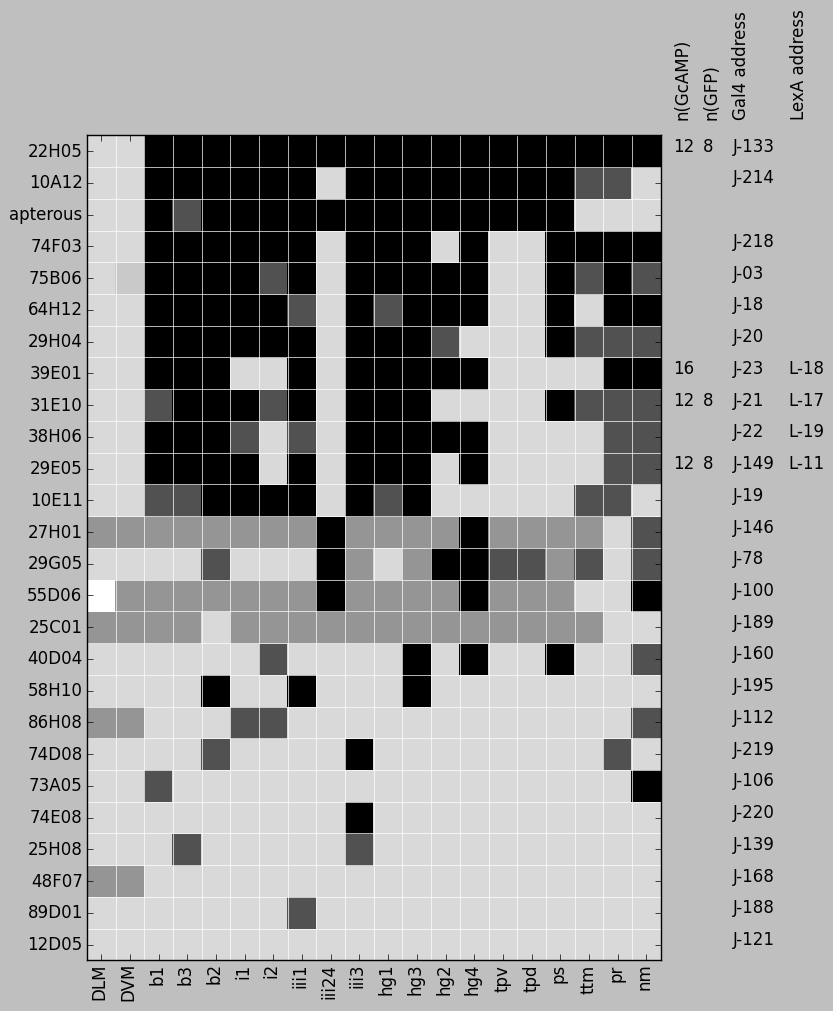

In [10]:
#plot the matrix
fig = plb.figure(figsize = (8.5,11))
nline,nmusc = np.shape(imgarray)
sortkeys = np.nansum(imgarray,axis=1)
sidx = np.argsort(sortkeys)
pltarray = imgarray[sidx,:]
pltarray = imgarray[sidx,:]
trim_lines = 0
plb.pcolor(pltarray[trim_lines:,:],cmap = plb.cm.Greys,vmin = 0,vmax=2)
lns = [plb.plot([x,x],[0,nline-trim_lines],color = 'w',lw =0.5) for x in range(nmusc)]
lns = [plb.plot([0,nmusc],[x,x],color = 'w',lw =0.5) for x in range(nline-trim_lines)]
nms = linenames[sidx][trim_lines:]
plb.yticks(arange(0,nline-trim_lines)+0.5)
tlbs = plb.gca().set_yticklabels(nms)
plb.xticks(arange(0,len(muscle_names))+0.5,rotation = 'vertical')
mlbs = plb.gca().set_xticklabels(muscle_names)
gca().set_xbound(0,nmusc)
gca().set_ybound(0,nline)

for i,nm in enumerate(nms):
    try:
        gca().text(len(mlbs)+0.5,i+0.5,'%s'%line_info_dict[nm]['n(GC)'])
        gca().text(len(mlbs)+1.5,i+0.5,'%s'%line_info_dict[nm]['n(GFP)'])
        gca().text(len(mlbs)+2.5,i+0.5,'%s'%line_info_dict[nm]['gal'])
        gca().text(len(mlbs)+4.5,i+0.5,'%s'%line_info_dict[nm]['lex'])
    except KeyError:
        pass
gca().text(len(mlbs)+0.5,len(nms)+0.5,'n(GcAMP)',va = 'bottom',rotation = 'vertical')
gca().text(len(mlbs)+1.5,len(nms)+0.5,'n(GFP)',  va = 'bottom',rotation = 'vertical')
gca().text(len(mlbs)+2.5,len(nms)+0.5,'Gal4 address', va = 'bottom',rotation = 'vertical')
gca().text(len(mlbs)+4.5,len(nms)+0.5,'LexA address', va = 'bottom',rotation = 'vertical')

fig.subplots_adjust(right = 0.8)
fig.subplots_adjust(top = 0.85)
#place plot 
display(plb.gcf())
savefig('line_profile.pdf')
plb.close()

In [18]:
model_file =  '../muscle_segmentation/model_data.cpkl'

In [19]:
import cPickle as cpkl

In [20]:
f = open(model_file);model_data = cpkl.load(f);f.close()

In [21]:
class Basis(dict):    
    def __setitem__(self,key,item):
        """overload the __setitem__ method of dict so the transform and inverse
         transform matrices are computed when the basis vectors are changed"""
        try:
            if key in ['a1','a2']:
                dict.__setitem__(self,key,item)
                A = np.vstack((self['a1'],self['a2'])).T
                A_inv = np.linalg.inv(A)
                self['A'] = A
                self['A_inv'] = A_inv
            else:
                dict.__setitem__(self,key,item)
        except KeyError:
            dict.__setitem__(self,key,item)
                
        
class GeometricModel(object):   
    def __init__(self,lines,basis):
        self.lines = lines
        self.basis = basis
        ## put lines in barycentric coords
        self.barycentric = dict()
        for key in self.lines.keys():
            coords = dot(self.basis['A_inv'],(self.lines[key]-self.basis['p'][:,newaxis])) 
            self.barycentric[key] = coords.T
            
    def coords_from_basis(self,basis):
        ret = dict()
        for key in self.barycentric.keys():
            coords = np.dot(basis['A'],(self.barycentric[key]).T)+basis['p'][:,newaxis]
            ret[key] = coords
        return(ret)

class ModelView(object):
    def __init__(self,model):
        self.model = model
        
    def plot(self,basis,**kwargs):
        lines = self.model.coords_from_basis(basis)
        plot_args = {}
        plot_args['plot_frame'] = kwargs.pop('plot_frame',True)
        plot_args['frame_head_width'] = kwargs.pop('frame_head_width',20)
        plot_args['contour_color'] = kwargs.pop('contour_color','w')
        
        kwargs['color'] = plot_args['contour_color']
        for line in lines.values():
            plot(line[0,:],line[1,:], **kwargs)
        if plot_args['plot_frame']:
            p = basis['p']
            a1 = basis['a1']
            a2 = basis['a2']
            kwargs['color'] = 'g'
            kwargs['head_width'] = plot_args['frame_head_width']
            arrow(p[0],p[1],a1[0],a1[1],**kwargs)
            kwargs['color'] = 'b'
            kwargs['head_width'] = plot_args['frame_head_width']
            arrow(p[0],p[1],a2[0],a2[1],**kwargs)

In [22]:
#figure(figsize = (10,10))
#imfile = tifffile.TiffFile('muscle_viz.tiff')
#sumimg = imfile.asarray()

###add position of large setae 
model_data['e1'] = np.array([[ 170.02788104,  326.71685254],
                             [ 380.98203222,  919.92627014]])
model_data['e2'] = array([[ 172.83333333,  332.83333333],
                          [ 551.5       ,  164.83333333]])
e1 = model_data['e1']
e2 = model_data['e2']
muscles = dict()

for key in model_data.keys():
    if not(key in ['e1','e2']):
        muscles[key] = model_data[key]
        
confocal_basis = Basis()
confocal_basis['a1'] = e2[1]-e2[0]
confocal_basis['a2'] = e1[1]-e2[0]
confocal_basis['p'] = e2[0]

thorax = GeometricModel(muscles,confocal_basis)
thorax_view = ModelView(thorax)

#imshow(sumimg)
import copy
#thorax_view.plot(thorax.basis)
#gca().axis('tight')
#display(gcf());close()

In [23]:
def plot_line(line_name):
    idx = where(nms == line_name)[0]
    muscle_bool = squeeze(pltarray[idx] > 0.5).astype(bool)
    line_mus = np.array(muscle_names)[muscle_bool]
    
    xp,yp = meshgrid(arange(1024),arange(1024))
    pnts = vstack((xp.ravel(),yp.ravel()))
    mask = zeros((1024,1024))
    for key in line_mus:
        if key not in ['DLM','DVM','tt','vtp','ps']:
            if key == 'dtp':
                key = 'tp'
            p = matplotlib.path.Path(model_data[key].T)
            mask += p.contains_points(pnts.T).reshape(1024,1024)
    imshow(mask)
    thorax_view.plot(thorax.basis)
    gca().set_title(line_name)
    gca().set_xbound(0,750)
    gca().set_ybound(100,1024)
    gca().set_xticklabels([])
    gca().set_yticklabels([])

In [24]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(5, 5)
for lin_num in arange(0,len(nms)):
    x,y = where(arange(0,25).reshape(5,5) == lin_num)
    ax = plt.subplot(gs[x[0], y[0]])
    plot_line(nms[lin_num])

In [300]:
ax = gca()

In [278]:
ax.set_title()

(23,)

In [232]:
nms

array(['12D05', '89D01', '25H08', '48F07', '73A05', '40D04', '58H10',
       '86H08', '29E05', '10E11', '39E01', '29G05', '38H06', '64H12',
       '10A12', 'apterous', '29H04', '75B06', '55D06', '31E10', '25C01',
       '27H01', '22H05'], 
      dtype='|S34')

In [227]:
shape(muscle_names)

(20,)

In [226]:
shape(muscle_bool)

(20,)